In [6]:
import os
import re
import datetime as dt
import pandas as pd
import numpy as np
import cudf
import cupy as cp
from pathlib import Path

In [7]:
start_date = dt.datetime(2024,10,15)
end_date  = dt.datetime(2024,10,31)
symbol = "BTC-USDT" #spot
exchange = "BINANCE"

In [9]:
def quality_report(
        symbol: str,
        start_date: str | dt.datetime,
        end_date: str | dt.datetime,
        data_dir: str = "./data",
        cols: tuple[str,...] = ("origin_time", "received_time"),
        data_type: str = "raw",  # 'raw' or 'normalized'
        depth: int = 20,  # max depth level for LOB data
):
    """
    Fájl-streamelt min/max + gap statisztika – max. 1 fájl a GPU-n
    
    Args:
        symbol: Kereskedési pár (pl. BTC-USDT)
        start_date: Kezdő dátum
        end_date: Végső dátum
        data_dir: Adatkönyvtár
        cols: Oszlopok listája (alapértelmezetten időbélyegek)
        data_type: 'raw' a nyers LOB adatokhoz, 'normalized' a normalizált adatokhoz
        depth: Maximum mélység a LOB adatokhoz
    """
    # ---- előkészítés -------------------------------------------------------
    sym_pat = symbol.lower().replace("-", "_")
    
    # Fájlnév minta a data_type alapján
    if data_type == "normalized":
        rex = re.compile(rf"norm_book_{sym_pat}_(\d{{8}})_(\d{{8}})\.parquet$")
    else:  # raw
        rex = re.compile(rf"book_{sym_pat}_(\d{{8}})_(\d{{8}})\.parquet$")
    
    sd = pd.to_datetime(start_date)
    ed = pd.to_datetime(end_date)

    # ---- globális statok (inkrementálisan frissítjük) ----------------------
    min_o = max_o = min_r = max_r = None
    rec_cnt = 0
    largest_gap = pd.Timedelta(0)
    largest_gap_start = None
    missing_secs = set()
    
    # Ha LOB feature-öket vizsgálunk, gyűjtsük ezeket
    if data_type in ["raw", "normalized"]:
        # LOB oszlopok generálása a depth alapján
        lob_cols = []
        for side in ['bid', 'ask']:
            for i in range(depth):
                lob_cols.append(f"{side}_{i}_price")
                lob_cols.append(f"{side}_{i}_size")
        
        # Minden oszlop, amit be akarunk olvasni
        all_cols = list(cols)
        if data_type == "raw":
            all_cols.extend(lob_cols)
        else:  # normalized esetén már minden oszlop normalizált
            all_cols.extend(lob_cols)
    else:
        all_cols = list(cols)
    
    # Minta DataFrame tárolásra a head() kiíratáshoz
    sample_df = None

    # ---- stream feldolgozás fájlról fájlra ---------------------------------
    for fn in sorted(os.listdir(data_dir)):
        m = rex.match(fn)
        if not m:
            continue
        f_sd = pd.to_datetime(m.group(1))
        f_ed = pd.to_datetime(m.group(2))
        if f_ed < sd or f_sd > ed:
            continue

        fp = os.path.join(data_dir, fn)
        print(f"Olvasás: {fp}")
        
        try:
            df = cudf.read_parquet(fp, columns=all_cols, engine="cudf")
        except Exception as e:
            print(f"Hiba a fájl olvasásakor: {e}")
            continue

        # ↓↓↓   csak a kért dátumtartomány
        if "received_time" in df.columns:
            df = df[
                (df["received_time"] >= sd) &
                (df["received_time"] <= ed)
            ]

        if df.empty:
            continue

        # Az első nem üres DataFrame-et elmentjük mintának
        if sample_df is None:
            sample_df = df.head(10).copy()

        # ------- min / max frissítés (csak ha időbélyegek vannak) ----------
        if "origin_time" in df.columns and "received_time" in df.columns:
            o_min, o_max = df["origin_time"].min(), df["origin_time"].max()
            r_min, r_max = df["received_time"].min(), df["received_time"].max()

            min_o = o_min if min_o is None else min(min_o, o_min)
            max_o = o_max if max_o is None else max(max_o, o_max)
            min_r = r_min if min_r is None else min(min_r, r_min)
            max_r = r_max if max_r is None else max(max_r, r_max)

            # ------- gaps a received_time alapján --------------------------
            recv_sorted = df["received_time"].sort_values().to_pandas()
            gaps = recv_sorted.diff().dropna()
            if not gaps.empty and gaps.max() > largest_gap:
                largest_gap = gaps.max()
                largest_gap_start = recv_sorted.iloc[gaps.argmax()]

            # ------- hiányzó másodpercek (set-union) -----------------------
            secs = recv_sorted.dt.floor("s").unique()
            missing_secs.update(
                pd.date_range(secs.min(), secs.max(), freq="s").difference(secs)
            )

        rec_cnt += len(df)

        # ------- memória felszabadítás GPU-n -------------------------------
        del df
        cp.get_default_memory_pool().free_all_blocks()

    # ---- report ------------------------------------------------------------
    print(f"\n[GPU stream report] {symbol} - {data_type.upper()} data")
    print(f"    idősáv: {sd}  →  {ed}")
    
    # Időbélyeg statisztikák (ha vannak)
    if min_r is not None and max_r is not None:
        dur_r = (max_r - min_r) / np.timedelta64(1, "s") if rec_cnt else 0
        print(f"\nOrigin_time:   {min_o}  →  {max_o}")
        print(f"Received_time: {min_r}  →  {max_r}")
        print(f"Records: {rec_cnt:,}")
        print(f"Avg rec/s: {rec_cnt/dur_r:.2f}")
        print(f"\nLargest gap: {largest_gap/np.timedelta64(1,'s'):.2f} s")
        print(f"Gap start  : {largest_gap_start}")
        print(f"\nMissing whole seconds: {len(missing_secs):,}")
    else:
        print(f"\nRecords: {rec_cnt:,}")
    
    # Minta adatok kiíratása
    if sample_df is not None:
        print("\n--- Első 10 sor minta (head) ---")
        # Pandas-ra konvertáljuk, hogy megfelelően jelenjen meg a notebook-ban
        pd_sample = sample_df.to_pandas()
        
        # Teljes megjelenítés beállítása (ne legyen truncated)
        with pd.option_context('display.max_columns', None, 'display.width', None):
            print(pd_sample)
    else:
        print("\nNincs adat a megadott paraméterekkel.")

In [ ]:
# Nyers LOB adatok ellenőrzéséhez
quality_report(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    data_dir="./data",
    data_type="raw",
)

In [10]:
# Normalizált adatok ellenőrzéséhez
quality_report(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    data_dir="./data_normalized",  # normalizált adatok mappája
    data_type="normalized",
)

Olvasás: ./data_normalized/norm_book_btc_usdt_20241001_20241015.parquet
Olvasás: ./data_normalized/norm_book_btc_usdt_20241015_20241031.parquet

[GPU stream report] BTC-USDT - NORMALIZED data
    idősáv: 2024-10-15 00:00:00  →  2024-10-31 00:00:00

Origin_time:   1970-01-01T00:00:00.000000000  →  2024-10-30T23:59:59.813999872
Received_time: 2024-10-15T00:00:00.016179456  →  2024-10-30T23:59:59.816037376
Records: 8,731,084
Avg rec/s: 6.32

Largest gap: 10.28 s
Gap start  : 2024-10-29 04:52:01.216084224

Missing whole seconds: 205

--- Első 10 sor minta (head) ---
                    origin_time                 received_time  bid_0_price  \
0 2024-10-15 00:00:00.013999872 2024-10-15 00:00:00.016179456    -1.450553   
1 2024-10-15 00:00:00.348000000 2024-10-15 00:00:01.021205248    -1.438696   
2 2024-10-15 00:00:00.513999872 2024-10-15 00:00:01.497387008    -1.438696   
3 2024-10-15 00:00:00.813999872 2024-10-15 00:00:01.909351168    -1.441234   
4 2024-10-15 00:00:00.914000128 2024-10-1

In [ ]:
def analyze_lob_features(df_book, depth=20, sample=1_000_000):
    """Basic LOB feature quality analysis"""
    import cudf
    import cupy as cp
    import re
    
    # Get LOB feature columns
    pat = r'(bid|ask)_[0-9]{1,2}_(price|size)'
    feat_cols = [c for c in df_book.columns 
                if re.match(pat, c) and int(c.split('_')[1]) < depth]
    
    # Stats collection
    rows = []
    
    for col in feat_cols:
        s = df_book[col]
        
        # Parse column info
        parts = col.split('_')
        side = parts[0]
        level = int(parts[1])
        metric = parts[2]
        
        # Calculate stats
        miss_pct = float(s.isna().mean() * 100)
        zeros_pct = float((s == 0).mean() * 100) if cudf.api.types.is_numeric_dtype(s.dtype) else None
        
        # Sample for performance if needed
        s_sample = s.sample(sample, random_state=0) if sample and len(s) > sample else s
        
        # Get basic stats
        mn = float(s.min())
        mx = float(s.max())
        mean = float(s_sample.mean())
        std = float(s_sample.std())
        
        # Quantiles
        q = s_sample.quantile([0.01, 0.25, 0.5, 0.75, 0.99])
        p01, p25, p50, p75, p99 = [float(q.iloc[i]) for i in range(5)]
        
        rows.append({
            "feature": col,
            "side": side,
            "level": level,
            "metric": metric,
            "missing_%": miss_pct,
            "zeros_%": zeros_pct,
            "min": mn,
            "p01": p01,
            "p25": p25,
            "median": p50,
            "p75": p75,
            "p99": p99,
            "max": mx,
            "mean": mean,
            "std": std,
            "cv": std/mean if mean != 0 else None
        })
        
        # GPU memory cleanup
        del s, s_sample
        cp.get_default_memory_pool().free_all_blocks()
    
    # Create report DataFrame
    report = cudf.DataFrame(rows)
    
    # Check for price issues (fixing the comparison error)
    price_issues = []
    
    # Convert to pandas for easier comparisons
    pdf = report.to_pandas()
    
    # Check bid prices (should be decreasing with level)
    bid_prices = pdf[(pdf["side"] == "bid") & (pdf["metric"] == "price")].sort_values("level")
    if len(bid_prices) > 1:
        prev_median = None
        for _, row in bid_prices.iterrows():
            if prev_median is not None and prev_median < row["median"]:
                price_issues.append(f"Bid price inversion at level {row['level']}")
            prev_median = row["median"]
    
    # Check ask prices (should be increasing with level)
    ask_prices = pdf[(pdf["side"] == "ask") & (pdf["metric"] == "price")].sort_values("level")
    if len(ask_prices) > 1:
        prev_median = None
        for _, row in ask_prices.iterrows():
            if prev_median is not None and prev_median > row["median"]:
                price_issues.append(f"Ask price inversion at level {row['level']}")
            prev_median = row["median"]
    
    # Check spread
    if not bid_prices.empty and not ask_prices.empty:
        best_bid = bid_prices[bid_prices["level"] == 0]["median"].values[0] if 0 in bid_prices["level"].values else None
        best_ask = ask_prices[ask_prices["level"] == 0]["median"].values[0] if 0 in ask_prices["level"].values else None
        
        if best_bid is not None and best_ask is not None and best_bid >= best_ask:
            price_issues.append(f"Negative/zero spread: best_bid={best_bid}, best_ask={best_ask}")
    
    # Print issues if any
    if price_issues:
        print("Price issues detected:")
        for issue in price_issues:
            print(f"- {issue}")
    
    return report

# Simple usage
def check_lob_features(df_book):
    print(f"Data shape: {df_book.shape}")
    report = analyze_lob_features(df_book)
    print(f"Features analyzed: {len(report)}")
    return report

report = check_lob_features(df_book)
print(report.to_pandas())  # For viewing

Fájl betöltése: ./results/deeplob/predictions_deeplob_single_parallel_f1_0_20250301_20250302.parquet

=== Alapvető információk ===
Rekordok száma: 429,842
Oszlopok: received_time, ask_0_price, prediction

=== Időszak elemzés ===
Kezdő időpont: 2025-03-01 00:00:00.023702272
Végső időpont: 2025-03-01 18:17:50.616430592
Időtartam: 0 days 18:17:50.592728320

Mintavételezési statisztikák:
Átlagos időköz: 0.153 másodperc
Minimális időköz: 0.051 másodperc
Maximális időköz: 2.963 másodperc
Szórás: 0.083 másodperc

=== Predikciók eloszlása ===

Predikciók száma és százaléka:
Down: 206,380 (48.01%)
Stable: 34,042 (7.92%)
Up: 189,420 (44.07%)

=== Árfolyam statisztikák ===
Minimum ár: -0.97
Maximum ár: -0.12
Átlagos ár: -0.61
Ár szórás: 0.15

Árfolyam változások:
Átlagos változás: 0.00
Maximális növekedés: 0.03
Maximális csökkenés: -0.03

=== Predikciók és árfolyam változások összefüggése ===
Predikciók pontossága: 10.92%

=== Időszakonkénti elemzés ===

Óránkénti statisztikák:
      Rekordok  Do

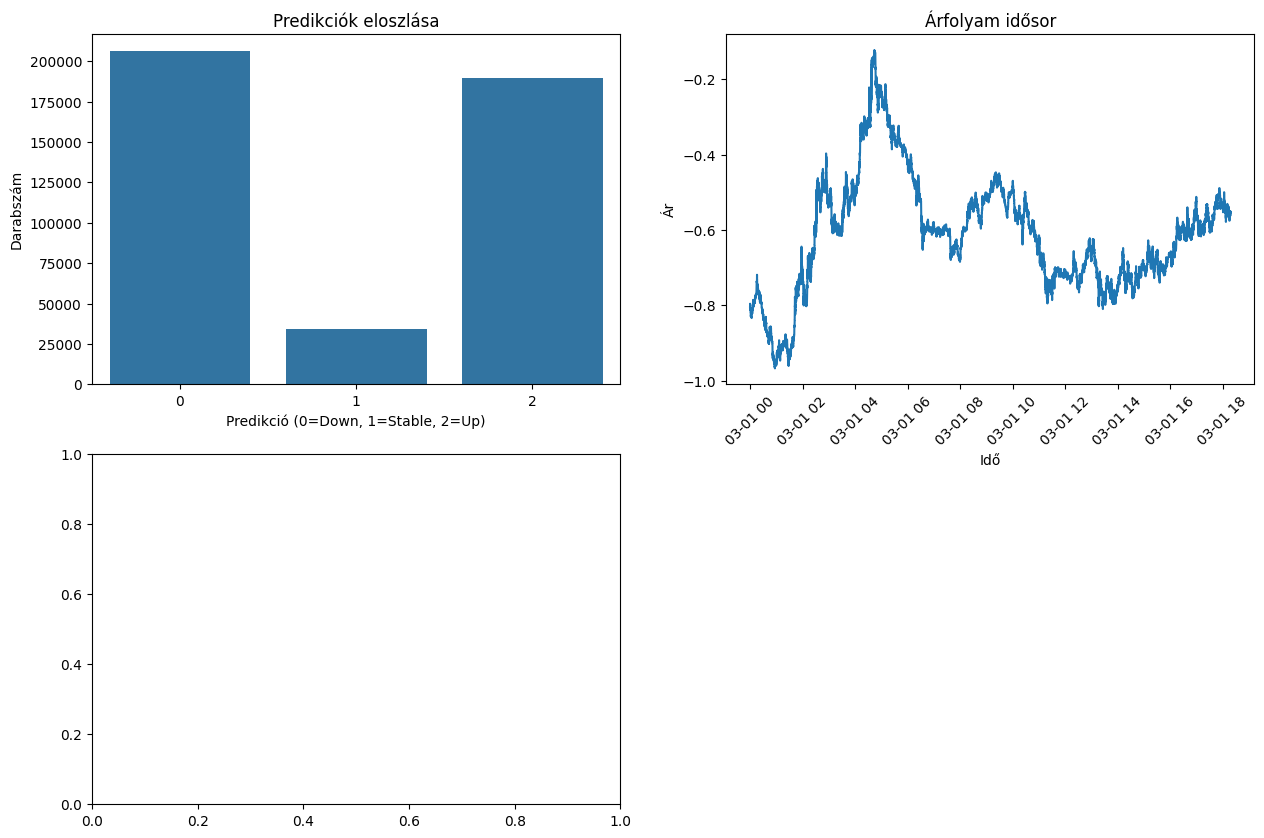

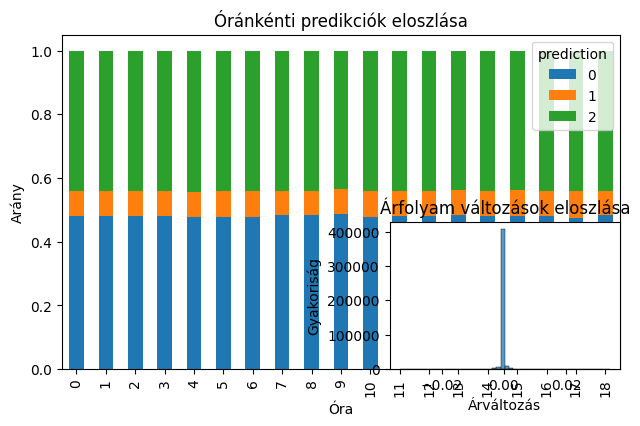

In [6]:
"""
Predikciós fájl elemzése - Részletes statisztikák és vizualizációk
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def analyze_predictions_file(file_path):
    """
    Részletes elemzés a predikciós fájlról.
    
    Args:
        file_path: A predikciós fájl elérési útja
    """
    print(f"Fájl betöltése: {file_path}")
    df = pd.read_parquet(file_path)
    
    print("\n=== Alapvető információk ===")
    print(f"Rekordok száma: {len(df):,}")
    print(f"Oszlopok: {', '.join(df.columns)}")
    
    print("\n=== Időszak elemzés ===")
    print(f"Kezdő időpont: {df['received_time'].min()}")
    print(f"Végső időpont: {df['received_time'].max()}")
    print(f"Időtartam: {df['received_time'].max() - df['received_time'].min()}")

    # Időbeli mintavételezés ellenőrzése
    time_diffs = df['received_time'].diff().dropna()
    time_diffs_seconds = time_diffs.dt.total_seconds()  # Konvertálás másodpercekre

    print(f"\nMintavételezési statisztikák:")
    print(f"Átlagos időköz: {time_diffs_seconds.mean():.3f} másodperc")
    print(f"Minimális időköz: {time_diffs_seconds.min():.3f} másodperc")
    print(f"Maximális időköz: {time_diffs_seconds.max():.3f} másodperc")
    print(f"Szórás: {time_diffs_seconds.std():.3f} másodperc") 
    
    print("\n=== Predikciók eloszlása ===")
    pred_counts = df['prediction'].value_counts().sort_index()
    pred_percentages = (pred_counts / len(df) * 100).round(2)
    
    print("\nPredikciók száma és százaléka:")
    for pred, count in pred_counts.items():
        pred_name = {0: "Down", 1: "Stable", 2: "Up"}[pred]
        print(f"{pred_name}: {count:,} ({pred_percentages[pred]}%)")
    
    print("\n=== Árfolyam statisztikák ===")
    print(f"Minimum ár: {df['ask_0_price'].min():.2f}")
    print(f"Maximum ár: {df['ask_0_price'].max():.2f}")
    print(f"Átlagos ár: {df['ask_0_price'].mean():.2f}")
    print(f"Ár szórás: {df['ask_0_price'].std():.2f}")
    
    # Árfolyam változások elemzése
    price_changes = df['ask_0_price'].diff().dropna()
    print("\nÁrfolyam változások:")
    print(f"Átlagos változás: {price_changes.mean():.2f}")
    print(f"Maximális növekedés: {price_changes.max():.2f}")
    print(f"Maximális csökkenés: {price_changes.min():.2f}")
    
    # Predikciók és árfolyam változások összefüggése
    print("\n=== Predikciók és árfolyam változások összefüggése ===")
    df['price_change'] = df['ask_0_price'].diff()
    df['price_direction'] = np.where(df['price_change'] > 0, 2, 
                                   np.where(df['price_change'] < 0, 0, 1))
    
    # Predikciók pontossága
    correct_predictions = (df['prediction'] == df['price_direction']).sum()
    accuracy = (correct_predictions / len(df)) * 100
    
    print(f"Predikciók pontossága: {accuracy:.2f}%")
    
    # Időszakonkénti elemzés
    print("\n=== Időszakonkénti elemzés ===")
    df['hour'] = df['received_time'].dt.hour
    
    hourly_stats = df.groupby('hour').agg({
        'prediction': ['count', lambda x: (x == 0).mean() * 100,  # Down %
                      lambda x: (x == 1).mean() * 100,  # Stable %
                      lambda x: (x == 2).mean() * 100],  # Up %
        'ask_0_price': ['mean', 'std']
    }).round(2)
    
    hourly_stats.columns = ['Rekordok', 'Down %', 'Stable %', 'Up %', 'Átlag ár', 'Ár szórás']
    print("\nÓránkénti statisztikák:")
    print(hourly_stats)
    
    # Vizualizációk
    plt.figure(figsize=(15, 10))
    
    # 1. Predikciók eloszlása
    plt.subplot(2, 2, 1)
    sns.countplot(data=df, x='prediction')
    plt.title('Predikciók eloszlása')
    plt.xlabel('Predikció (0=Down, 1=Stable, 2=Up)')
    plt.ylabel('Darabszám')
    
    # 2. Árfolyam idősor
    plt.subplot(2, 2, 2)
    plt.plot(df['received_time'], df['ask_0_price'])
    plt.title('Árfolyam idősor')
    plt.xlabel('Idő')
    plt.ylabel('Ár')
    plt.xticks(rotation=45)
    
    # 3. Óránkénti predikciók
    plt.subplot(2, 2, 3)
    hourly_preds = df.groupby('hour')['prediction'].value_counts(normalize=True).unstack()
    hourly_preds.plot(kind='bar', stacked=True)
    plt.title('Óránkénti predikciók eloszlása')
    plt.xlabel('Óra')
    plt.ylabel('Arány')
    
    # 4. Árfolyam változások eloszlása
    plt.subplot(2, 2, 4)
    sns.histplot(df['ask_0_price'].diff().dropna(), bins=50)
    plt.title('Árfolyam változások eloszlása')
    plt.xlabel('Árváltozás')
    plt.ylabel('Gyakoriság')
    
    plt.tight_layout()
    
    # Mentés a results/analysis mappába
    output_dir = "./szakdolgozat-high-freq-btc-prediction/results/analysis"
    os.makedirs(output_dir, exist_ok=True)
    
    # Fájlnév generálása az aktuális időbélyeggel
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = os.path.join(output_dir, f"prediction_analysis_{timestamp}.png")
    
    plt.savefig(output_file)
    print(f"\nVizualizációk mentve: {output_file}")
    
    return df

if __name__ == "__main__":
    prediction_file = "./results/deeplob/predictions_deeplob_single_parallel_f1_0_20250301_20250302.parquet"
    df = analyze_predictions_file(prediction_file) 